# Crossover and Mutation Operators for FloatSolution in jMetalPy

This notebook provides a comprehensive tutorial on the **crossover** and **mutation** operators available in jMetalPy for real-valued (`FloatSolution`) optimization.

## Contents

1. [Setup and imports](#setup)
2. [Operator architecture overview](#architecture)
3. [Crossover operators](#crossover)
   - SBXCrossover, BLXAlphaCrossover, ArithmeticCrossover, DifferentialEvolutionCrossover
4. [Mutation operators](#mutation)
   - PolynomialMutation, UniformMutation, SimpleRandomMutation, NonUniformMutation, LevyFlightMutation
5. [Repair strategies](#repair)
   - ClampFloatRepair, RandomUniformRepair, ReflectiveRepair
6. [Visualizations: distribution plots](#viz)
7. [Reproducibility with RNG injection](#rng)
8. [Summary](#summary)

<a id="setup"></a>
## 1. Setup and Imports

First, we import the necessary modules. We set a reproducible RNG seed for all examples.

In [8]:
import sys
import numpy as np
import matplotlib.pyplot as plt

# Reproducible random generator
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

# Import jMetalPy operators
from jmetal.core.solution import FloatSolution
from jmetal.operator.crossover import (
    SBXCrossover,
    BLXAlphaCrossover,
    BLXAlphaBetaCrossover,
    ArithmeticCrossover,
    DifferentialEvolutionCrossover,
)
from jmetal.operator.mutation import (
    PolynomialMutation,
    UniformMutation,
    SimpleRandomMutation,
    NonUniformMutation,
    LevyFlightMutation,
    PowerLawMutation,
)
from jmetal.operator.repair import (
    ClampFloatRepair,
    RandomUniformRepair,
    ReflectiveRepair,
    BoundSwapRepair,
)

print("jMetalPy operators imported successfully!")
print(f"NumPy version: {np.__version__}")

jMetalPy operators imported successfully!
NumPy version: 2.3.4


<a id="architecture"></a>
## 2. Operator Architecture Overview

### Base Classes
- **`Crossover[S, R]`**: Base class for crossover operators. Key methods:
  - `execute(parents: List[S]) -> List[R]`: Perform the crossover
  - `get_number_of_parents()`, `get_number_of_children()`
  - `get_name()`: Returns operator name
  
- **`Mutation[S]`**: Base class for mutation operators. Key methods:
  - `execute(solution: S) -> S`: Mutate a solution in-place
  - `get_name()`: Returns operator name

### Common Parameters
| Parameter | Description |
|-----------|-------------|
| `probability` | Probability of applying the operator (0.0 to 1.0) |
| `distribution_index` | Controls spread of offspring (higher = closer to parents) |
| `repair_operator` | Strategy to handle out-of-bounds values |
| `rng` | NumPy random Generator for reproducibility |

### Crossover Operators for FloatSolution

| Operator | Key Parameters | Description |
|----------|----------------|-------------|
| `SBXCrossover` | `probability`, `distribution_index` (20.0) | Simulated Binary Crossover - mimics single-point crossover in continuous space |
| `BLXAlphaCrossover` | `probability`, `alpha` (0.5) | Blend crossover - offspring sampled in extended parent range |
| `BLXAlphaBetaCrossover` | `probability`, `alpha`, `beta` | Asymmetric blend crossover |
| `ArithmeticCrossover` | `probability` | Linear combination of parents |
| `DifferentialEvolutionCrossover` | `CR`, `F`, `K` | DE-style mutation/crossover (requires 3 parents) |

### Mutation Operators for FloatSolution

| Operator | Key Parameters | Description |
|----------|----------------|-------------|
| `PolynomialMutation` | `probability`, `distribution_index` (20.0) | Standard polynomial perturbation |
| `UniformMutation` | `probability`, `perturbation` (0.5) | Uniform random perturbation scaled by range |
| `SimpleRandomMutation` | `probability` | Replace with uniform random in bounds |
| `NonUniformMutation` | `probability`, `perturbation`, `max_iterations` | Decreasing perturbation over time |
| `LevyFlightMutation` | `probability`, `beta`, `step_size` | Heavy-tailed Lévy flight steps |
| `PowerLawMutation` | `probability`, `delta` | Power-law distributed perturbations |

<a id="crossover"></a>
## 3. Crossover Operators

### 3.1 SBXCrossover (Simulated Binary Crossover)

SBX simulates single-point binary crossover in continuous space. The `distribution_index` controls offspring spread:
- **High values (>20)**: Offspring close to parents (exploitation)
- **Low values (<10)**: Offspring spread out (exploration)

In [9]:
# Create two parent solutions (5 variables in [0, 1])
def create_solution(values, lower=0.0, upper=1.0):
    """Helper to create a FloatSolution with given values."""
    n = len(values)
    sol = FloatSolution(
        lower_bound=[lower] * n,
        upper_bound=[upper] * n,
        number_of_objectives=2
    )
    sol._variables = list(values)
    return sol

# Parent solutions
parent1 = create_solution([0.2, 0.8, 0.5, 0.3, 0.7])
parent2 = create_solution([0.8, 0.2, 0.5, 0.7, 0.3])

print("Parent 1:", [f"{v:.3f}" for v in parent1.variables])
print("Parent 2:", [f"{v:.3f}" for v in parent2.variables])

# SBX with different distribution indices
for eta in [5, 20, 100]:
    rng_sbx = np.random.default_rng(42)  # Reset RNG for fair comparison
    sbx = SBXCrossover(probability=1.0, distribution_index=eta, rng=rng_sbx)
    offspring = sbx.execute([parent1, parent2])
    print(f"\nSBX (η={eta}):")
    print(f"  Child 1: {[f'{v:.3f}' for v in offspring[0].variables]}")
    print(f"  Child 2: {[f'{v:.3f}' for v in offspring[1].variables]}")

Parent 1: ['0.200', '0.800', '0.500', '0.300', '0.700']
Parent 2: ['0.800', '0.200', '0.500', '0.700', '0.300']

SBX (η=5):
  Child 1: ['0.138', '0.055', '0.500', '0.696', '0.700']
  Child 2: ['0.862', '0.945', '0.500', '0.304', '0.300']

SBX (η=20):
  Child 1: ['0.181', '0.154', '0.500', '0.699', '0.700']
  Child 2: ['0.819', '0.846', '0.500', '0.301', '0.300']

SBX (η=100):
  Child 1: ['0.196', '0.191', '0.500', '0.700', '0.700']
  Child 2: ['0.804', '0.809', '0.500', '0.300', '0.300']


### 3.2 BLXAlphaCrossover (Blend Crossover)

BLX-α creates offspring in an extended range around the parents:
- Range is expanded by `α * (max - min)` on each side
- `α = 0`: Offspring strictly between parents
- `α = 0.5`: Standard BLX-α (recommended)

In [10]:
# BLX-α crossover with different alpha values
for alpha in [0.0, 0.3, 0.5]:
    rng_blx = np.random.default_rng(42)
    blx = BLXAlphaCrossover(probability=1.0, alpha=alpha, rng=rng_blx)
    offspring = blx.execute([parent1, parent2])
    print(f"BLX-α (α={alpha}):")
    print(f"  Child 1: {[f'{v:.3f}' for v in offspring[0].variables]}")
    print(f"  Child 2: {[f'{v:.3f}' for v in offspring[1].variables]}\n")

BLX-α (α=0.0):
  Child 1: ['0.463', '0.618', '0.500', '0.614', '0.480']
  Child 2: ['0.715', '0.257', '0.500', '0.351', '0.448']

BLX-α (α=0.3):
  Child 1: ['0.441', '0.689', '0.500', '0.683', '0.468']
  Child 2: ['0.844', '0.110', '0.500', '0.262', '0.417']

BLX-α (α=0.5):
  Child 1: ['0.427', '0.737', '0.500', '0.729', '0.460']
  Child 2: ['0.930', '0.013', '0.500', '0.202', '0.397']



### 3.3 ArithmeticCrossover

Creates offspring as weighted averages of parents:
- `child1 = α * parent1 + (1-α) * parent2`
- `child2 = (1-α) * parent1 + α * parent2`

where α is randomly sampled for each crossover.

In [11]:
# Arithmetic crossover
arith = ArithmeticCrossover(probability=1.0)
arith._rng = np.random.default_rng(42)

offspring = arith.execute([parent1, parent2])
print("ArithmeticCrossover:")
print(f"  Parent 1: {[f'{v:.3f}' for v in parent1.variables]}")
print(f"  Parent 2: {[f'{v:.3f}' for v in parent2.variables]}")
print(f"  Child 1:  {[f'{v:.3f}' for v in offspring[0].variables]}")
print(f"  Child 2:  {[f'{v:.3f}' for v in offspring[1].variables]}")

ArithmeticCrossover:
  Parent 1: ['0.200', '0.800', '0.500', '0.300', '0.700']
  Parent 2: ['0.800', '0.200', '0.500', '0.700', '0.300']
  Child 1:  ['0.537', '0.463', '0.500', '0.524', '0.476']
  Child 2:  ['0.463', '0.537', '0.500', '0.476', '0.524']


<a id="mutation"></a>
## 4. Mutation Operators

### 4.1 PolynomialMutation

The standard mutation for real-coded GAs. Uses a polynomial distribution centered on the current value:
- `distribution_index` controls perturbation magnitude
- Lower values → larger mutations (exploration)
- Higher values → smaller mutations (exploitation)

In [12]:
# PolynomialMutation with different distribution indices
original = create_solution([0.5, 0.5, 0.5, 0.5, 0.5])
print(f"Original: {[f'{v:.3f}' for v in original.variables]}\n")

for eta in [5, 20, 100]:
    rng_pm = np.random.default_rng(42)
    pm = PolynomialMutation(probability=1.0, distribution_index=eta, rng=rng_pm)
    sol = create_solution([0.5, 0.5, 0.5, 0.5, 0.5])
    mutated = pm.execute(sol)
    diff = [abs(mutated.variables[i] - 0.5) for i in range(5)]
    print(f"PolynomialMutation (η={eta:3d}): {[f'{v:.3f}' for v in mutated.variables]}")
    print(f"  Avg perturbation: {np.mean(diff):.4f}")

Original: ['0.500', '0.500', '0.500', '0.500', '0.500']

PolynomialMutation (η=  5): ['0.479', '0.579', '0.868', '0.629', '0.483']
  Avg perturbation: 0.1228
PolynomialMutation (η= 20): ['0.494', '0.524', '0.634', '0.540', '0.495']
  Avg perturbation: 0.0417
PolynomialMutation (η=100): ['0.499', '0.505', '0.529', '0.508', '0.499']
  Avg perturbation: 0.0090


### 4.2 UniformMutation

Adds a uniform random perturbation scaled by the variable range:
- `perturbation`: controls maximum relative change (0.5 = ±25% of range)

In [21]:
# UniformMutation with different perturbation values
for pert in [0.1, 0.5, 1.0]:
    rng_um = np.random.default_rng(42)
    um = UniformMutation(probability=1.0, perturbation=pert, rng=rng_um)
    sol = create_solution([0.5, 0.5, 0.5, 0.5, 0.5])
    mutated = um.execute(sol)
    diff = [abs(mutated.variables[i] - 0.5) for i in range(5)]
    print(f"UniformMutation (perturbation={pert}): {[f'{v:.3f}' for v in mutated.variables]}")
    print(f"  Avg perturbation: {np.mean(diff):.4f}\n")

UniformMutation (perturbation=0.1): ['0.548', '0.526', '0.529', '0.463', '0.495']
  Avg perturbation: 0.0289

UniformMutation (perturbation=0.5): ['0.738', '0.631', '0.643', '0.314', '0.475']
  Avg perturbation: 0.1444

UniformMutation (perturbation=1.0): ['0.976', '0.761', '0.786', '0.128', '0.450']
  Avg perturbation: 0.2889



### 4.3 Other Mutation Operators

- **SimpleRandomMutation**: Replaces values with uniform random in bounds
- **LevyFlightMutation**: Heavy-tailed steps (occasional large jumps)
- **PowerLawMutation**: Power-law distributed perturbations

In [22]:
# Compare different mutation operators
print("Comparison of mutation operators (all with probability=1.0):\n")

mutations = [
    ("SimpleRandomMutation", SimpleRandomMutation(probability=1.0, rng=np.random.default_rng(42))),
    ("LevyFlightMutation", LevyFlightMutation(mutation_probability=1.0, beta=1.5, step_size=0.01, rng=np.random.default_rng(42))),
    ("PowerLawMutation", PowerLawMutation(probability=1.0, delta=1.0, rng=np.random.default_rng(42))),
]

for name, mut in mutations:
    sol = create_solution([0.5, 0.5, 0.5, 0.5, 0.5])
    mutated = mut.execute(sol)
    diff = [abs(mutated.variables[i] - 0.5) for i in range(5)]
    print(f"{name}:")
    print(f"  Result: {[f'{v:.3f}' for v in mutated.variables]}")
    print(f"  Avg perturbation: {np.mean(diff):.4f}\n")

Comparison of mutation operators (all with probability=1.0):

SimpleRandomMutation:
  Result: ['0.439', '0.697', '0.976', '0.786', '0.450']
  Avg perturbation: 0.2140

LevyFlightMutation:
  Result: ['0.491', '0.489', '0.466', '0.507', '0.513']
  Avg perturbation: 0.0148

PowerLawMutation:
  Result: ['0.539', '0.457', '0.494', '0.461', '0.530']
  Avg perturbation: 0.0314



<a id="repair"></a>
## 5. Repair Strategies

When operators produce values outside variable bounds, **repair operators** bring them back inside. Available strategies:

| Repair Operator | Behavior |
|-----------------|----------|
| `ClampFloatRepair` | Clip to nearest bound (default) |
| `RandomUniformRepair` | Resample uniformly within bounds |
| `ReflectiveRepair` | Reflect value at boundary (mirror) |
| `BoundSwapRepair` | Swap lower/upper if inverted |

In [23]:
# Demonstrate repair strategies
out_of_bounds_values = [-0.3, 1.5, 0.5, -0.1, 1.2]
lower, upper = 0.0, 1.0

repairs = [
    ("ClampFloatRepair", ClampFloatRepair()),
    ("RandomUniformRepair", RandomUniformRepair(rng=np.random.default_rng(42))),
    ("ReflectiveRepair", ReflectiveRepair()),
]

print(f"Original out-of-bounds values: {out_of_bounds_values}")
print(f"Bounds: [{lower}, {upper}]\n")

for name, repair in repairs:
    repaired = [repair.repair_scalar(v, lower, upper) for v in out_of_bounds_values]
    print(f"{name}: {[f'{v:.3f}' for v in repaired]}")

Original out-of-bounds values: [-0.3, 1.5, 0.5, -0.1, 1.2]
Bounds: [0.0, 1.0]

ClampFloatRepair: ['0.000', '1.000', '0.500', '0.000', '1.000']
RandomUniformRepair: ['0.774', '0.439', '0.500', '0.859', '0.697']
ReflectiveRepair: ['0.300', '0.500', '0.500', '0.100', '0.800']


### Using repair operators with mutation

Pass a repair operator to mutation constructors to customize boundary handling:

In [24]:
# Mutation with different repair strategies
# Use high perturbation to force out-of-bounds values
sol_near_bound = create_solution([0.05, 0.95, 0.02, 0.98, 0.5])
print(f"Original (near bounds): {[f'{v:.3f}' for v in sol_near_bound.variables]}\n")

for repair_name, repair in [("Clamp", ClampFloatRepair()), 
                            ("Reflective", ReflectiveRepair()),
                            ("RandomUniform", RandomUniformRepair(rng=np.random.default_rng(42)))]:
    rng_mut = np.random.default_rng(42)
    mut = UniformMutation(probability=1.0, perturbation=0.5, repair_operator=repair, rng=rng_mut)
    sol = create_solution([0.05, 0.95, 0.02, 0.98, 0.5])
    mutated = mut.execute(sol)
    print(f"UniformMutation + {repair_name}: {[f'{v:.3f}' for v in mutated.variables]}")

Original (near bounds): ['0.050', '0.950', '0.020', '0.980', '0.500']

UniformMutation + Clamp: ['0.288', '1.000', '0.163', '0.794', '0.475']
UniformMutation + Reflective: ['0.288', '0.919', '0.163', '0.794', '0.475']
UniformMutation + RandomUniform: ['0.288', '0.774', '0.163', '0.794', '0.475']


<a id="viz"></a>
## 6. Distribution Visualizations

Let's visualize how different operators affect the distribution of offspring values.

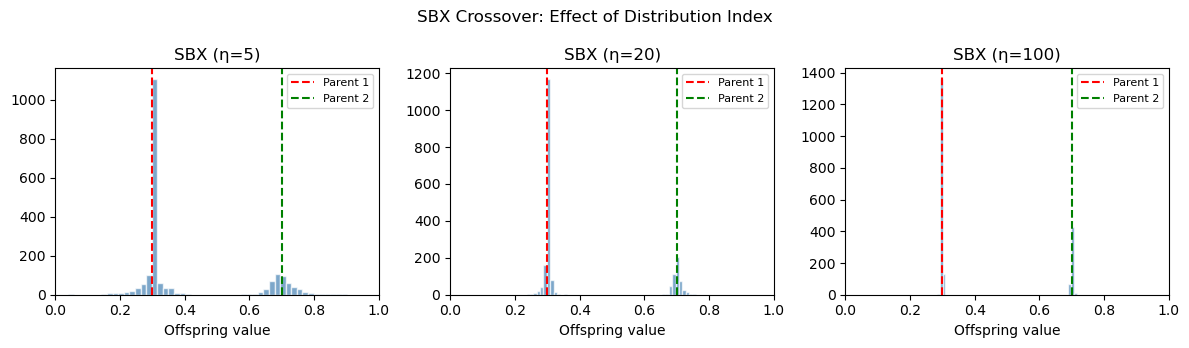

In [25]:
# Distribution of SBX offspring for different distribution indices
N_SAMPLES = 2000

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

for ax, eta in zip(axes, [5, 20, 100]):
    values = []
    for _ in range(N_SAMPLES):
        p1 = create_solution([0.3])
        p2 = create_solution([0.7])
        sbx = SBXCrossover(probability=1.0, distribution_index=eta)
        offspring = sbx.execute([p1, p2])
        values.append(offspring[0].variables[0])
    
    ax.hist(values, bins=50, color='steelblue', alpha=0.7, edgecolor='white')
    ax.axvline(0.3, color='red', linestyle='--', label='Parent 1')
    ax.axvline(0.7, color='green', linestyle='--', label='Parent 2')
    ax.set_title(f'SBX (η={eta})')
    ax.set_xlabel('Offspring value')
    ax.set_xlim(0, 1)
    ax.legend(fontsize=8)

plt.suptitle('SBX Crossover: Effect of Distribution Index', fontsize=12)
plt.tight_layout()
plt.show()

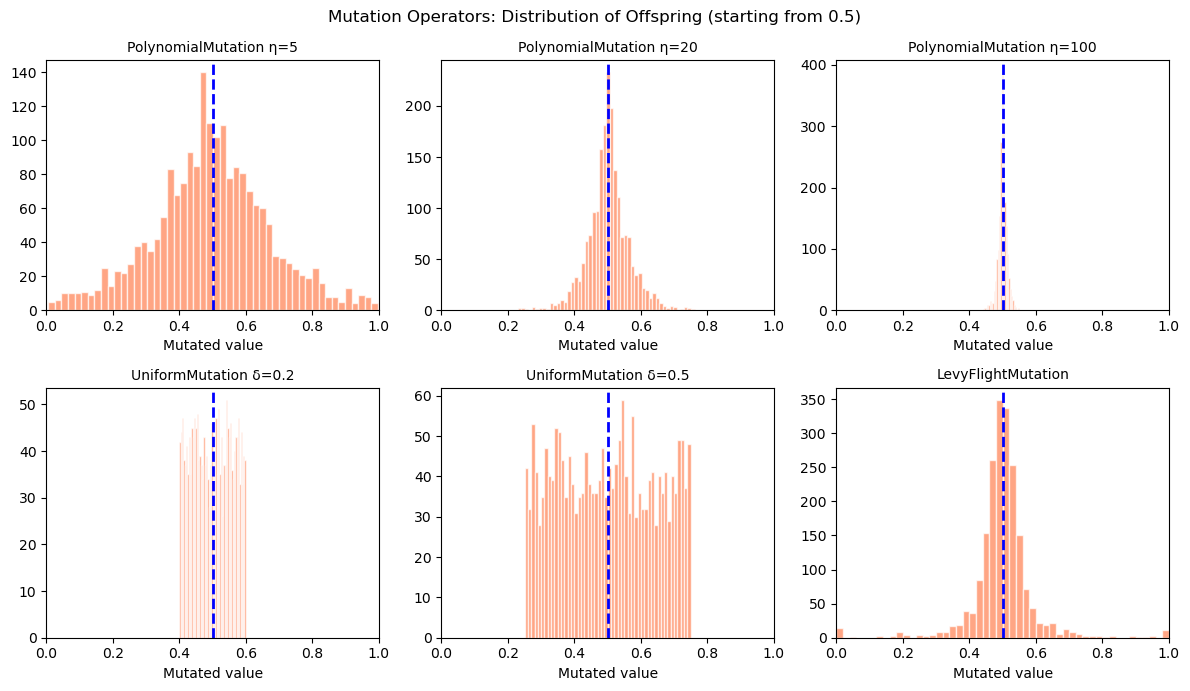

In [26]:
# Distribution of mutation operators starting from 0.5
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.flatten()

mutation_configs = [
    ("PolynomialMutation η=5", lambda: PolynomialMutation(probability=1.0, distribution_index=5)),
    ("PolynomialMutation η=20", lambda: PolynomialMutation(probability=1.0, distribution_index=20)),
    ("PolynomialMutation η=100", lambda: PolynomialMutation(probability=1.0, distribution_index=100)),
    ("UniformMutation δ=0.2", lambda: UniformMutation(probability=1.0, perturbation=0.2)),
    ("UniformMutation δ=0.5", lambda: UniformMutation(probability=1.0, perturbation=0.5)),
    ("LevyFlightMutation", lambda: LevyFlightMutation(mutation_probability=1.0, beta=1.5, step_size=0.05)),
]

for ax, (name, mut_factory) in zip(axes, mutation_configs):
    values = []
    for _ in range(N_SAMPLES):
        sol = create_solution([0.5])
        mut = mut_factory()
        mutated = mut.execute(sol)
        values.append(mutated.variables[0])
    
    ax.hist(values, bins=50, color='coral', alpha=0.7, edgecolor='white')
    ax.axvline(0.5, color='blue', linestyle='--', linewidth=2, label='Original')
    ax.set_title(name, fontsize=10)
    ax.set_xlabel('Mutated value')
    ax.set_xlim(0, 1)

plt.suptitle('Mutation Operators: Distribution of Offspring (starting from 0.5)', fontsize=12)
plt.tight_layout()
plt.show()

<a id="rng"></a>
## 7. Reproducibility with RNG Injection

All operators accept an optional `rng` parameter (a `numpy.random.Generator`) for reproducible results. This is essential for:
- Debugging
- Testing
- Reproducible experiments

In [27]:
# Demonstrate reproducibility with RNG injection
def run_sbx_with_seed(seed):
    """Run SBX crossover with a specific seed and return offspring values."""
    rng = np.random.default_rng(seed)
    p1 = create_solution([0.2, 0.8])
    p2 = create_solution([0.8, 0.2])
    sbx = SBXCrossover(probability=1.0, distribution_index=20, rng=rng)
    offspring = sbx.execute([p1, p2])
    return offspring[0].variables

# Same seed → same results
print("Reproducibility test:")
print(f"  Seed 123, Run 1: {run_sbx_with_seed(123)}")
print(f"  Seed 123, Run 2: {run_sbx_with_seed(123)}")
print(f"  Seed 456, Run 1: {run_sbx_with_seed(456)}")

# Verify they match
assert run_sbx_with_seed(123) == run_sbx_with_seed(123), "Results should be identical!"
print("\n✓ Reproducibility confirmed: same seed produces identical results")

Reproducibility test:
  Seed 123, Run 1: [0.7885203068716902, 0.1856888241588166]
  Seed 123, Run 2: [0.7885203068716902, 0.1856888241588166]
  Seed 456, Run 1: [0.21926609574835298, 0.8]

✓ Reproducibility confirmed: same seed produces identical results


<a id="summary"></a>
## 8. Summary

### Key Takeaways

1. **Crossover operators** combine parent solutions to create offspring:
   - `SBXCrossover`: Standard choice for real-coded GAs, `distribution_index` controls spread
   - `BLXAlphaCrossover`: Simple blend crossover, `alpha` controls exploration range
   - `ArithmeticCrossover`: Linear interpolation between parents

2. **Mutation operators** perturb individual solutions:
   - `PolynomialMutation`: Standard choice, `distribution_index` controls magnitude
   - `UniformMutation`: Simple uniform perturbation, `perturbation` controls range
   - `LevyFlightMutation`: Heavy-tailed steps for escaping local optima

3. **Repair strategies** handle out-of-bounds values:
   - `ClampFloatRepair`: Simple and fast (default)
   - `ReflectiveRepair`: Preserves distance from boundary
   - `RandomUniformRepair`: Adds randomness

4. **RNG injection** enables reproducible experiments:
   - Pass `rng=np.random.default_rng(seed)` to operators
   - Essential for debugging and scientific reproducibility

### Recommended Defaults

| Use Case | Crossover | Mutation |
|----------|-----------|----------|
| General optimization | `SBXCrossover(prob=0.9, η=20)` | `PolynomialMutation(prob=1/n_vars, η=20)` |
| More exploration | `BLXAlphaCrossover(prob=0.9, α=0.5)` | `UniformMutation(prob=0.1, δ=0.5)` |
| Escape local optima | - | `LevyFlightMutation(prob=0.05)` |

In [28]:
# Final example: Complete workflow with NSGA-II operators
print("Example: Typical operator configuration for NSGA-II")
print("=" * 50)

n_variables = 10
print(f"\nProblem with {n_variables} variables in [0, 1]:")

# Standard configuration
crossover = SBXCrossover(probability=0.9, distribution_index=20)
mutation = PolynomialMutation(probability=1.0/n_variables, distribution_index=20)

print(f"  Crossover: {crossover.get_name()}")
print(f"    - probability: 0.9")
print(f"    - distribution_index: 20")
print(f"  Mutation: {mutation.get_name()}")
print(f"    - probability: {1.0/n_variables:.3f} (1/n_variables)")
print(f"    - distribution_index: 20")

# Demonstrate one generation step
print("\nOne crossover + mutation step:")
p1 = create_solution(np.random.random(n_variables).tolist())
p2 = create_solution(np.random.random(n_variables).tolist())
offspring = crossover.execute([p1, p2])
child = mutation.execute(offspring[0])

print(f"  Parent 1 (first 3 vars): {[f'{v:.3f}' for v in p1.variables[:3]]}")
print(f"  Parent 2 (first 3 vars): {[f'{v:.3f}' for v in p2.variables[:3]]}")
print(f"  Child    (first 3 vars): {[f'{v:.3f}' for v in child.variables[:3]]}")

Example: Typical operator configuration for NSGA-II

Problem with 10 variables in [0, 1]:
  Crossover: SBX crossover
    - probability: 0.9
    - distribution_index: 20
  Mutation: Polynomial mutation
    - probability: 0.100 (1/n_variables)
    - distribution_index: 20

One crossover + mutation step:
  Parent 1 (first 3 vars): ['0.503', '0.203', '0.380']
  Parent 2 (first 3 vars): ['0.518', '0.129', '0.874']
  Child    (first 3 vars): ['0.503', '0.203', '0.350']
